In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import numpy as np

import ray
import models
import random,time
from time import sleep
import copy 
import datetime
import argparse
import sys


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import os
import shutil
from torch.utils.tensorboard import SummaryWriter
from filelock import FileLock

import pylab as pl
import pandas as pd 
import matplotlib.pyplot as plt

from models import channel_selection
from torchsummary import summary


/userhome/34/gyu/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/userhome/34/gyu/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/userhome/34/gyu/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)]

In [87]:
def load_ckpt_plot_bn_param(ckpt_path):
    checkpoint = torch.load(ckpt_path)
    if 'cfg' in checkpoint:
        model = models.__dict__['resnet'](dataset='cifar10', depth=164, cfg=checkpoint['cfg'])
    else:
        model = models.__dict__['resnet'](dataset='cifar10', depth=164)
    model.load_state_dict(checkpoint['state_dict'])                

    # calculate size of all bn parameters 
    total = 0
    module_list = list(model.modules())
    for i in range(len(module_list)):
        m = module_list[i]
        if (i + 1< len(module_list)) and isinstance(m, nn.BatchNorm2d) and isinstance(module_list[i+1],channel_selection):
            cs = module_list[i+1]
            total += int(torch.sum(cs.indexes))
        elif isinstance(m, nn.BatchNorm2d):
            total += m.weight.data.shape[0]
    
    # fill in bn params and flat it as 1-D
    bn = torch.zeros(total)

    index = 0
    for i in range(len(module_list)):
        m = module_list[i]
        if i+1 < len(module_list) and isinstance(m, nn.BatchNorm2d) and isinstance(module_list[i+1],channel_selection):
            cs = module_list[i+1]
            size = int(torch.sum(cs.indexes))
            mask = cs.indexes.clone().detach().numpy()
            bn[index:(index+size)] = torch.from_numpy(m.weight.data.abs().clone().numpy()[np.where(mask)])
            index += size
        elif isinstance(m, nn.BatchNorm2d):
            size = m.weight.data.shape[0]
            bn[index:(index+size)] = m.weight.data.abs().clone()
            index += size


    # sort by value
    sorted_bn, prev_idx = torch.sort(bn)
    
    
    s = pd.Series(sorted_bn)
#     count appearance of every value (dominanted by 0 with L1 norm)
    print('total # of bn params: ',len(bn))

    if 0 in s.value_counts():
        print("Value is 0 among all bn params: ",s.value_counts()[0])
        print("%.3f%% percent of bn params are zero"%(s.value_counts()[0] * 100.0 /len(bn)))

    plt.xlabel('BN weight value')
    plt.ylabel('# of BN params')
    plt.hist(s, bins=80, histtype="step", alpha=.8)


In [2]:
def plot_init_bn_param():
    model = models.__dict__['resnet'](dataset='cifar10', depth=164)

    # calculate size of all bn parameters 
    total = 0
    module_list = list(model.modules())
    for i in range(len(module_list)):
        m = module_list[i]
        if (i + 1< len(module_list)) and isinstance(m, nn.BatchNorm2d) and isinstance(module_list[i+1],channel_selection):
            cs = module_list[i+1]
            total += int(torch.sum(cs.indexes))
        elif isinstance(m, nn.BatchNorm2d):
            total += m.weight.data.shape[0]
    
    # fill in bn params and flat it as 1-D
    bn = torch.zeros(total)

    index = 0
    for i in range(len(module_list)):
        m = module_list[i]
        if i+1 < len(module_list) and isinstance(m, nn.BatchNorm2d) and isinstance(module_list[i+1],channel_selection):
            cs = module_list[i+1]
            size = int(torch.sum(cs.indexes))
            mask = cs.indexes.clone().detach().numpy()
            bn[index:(index+size)] = torch.from_numpy(m.weight.data.abs().clone().numpy()[np.where(mask)])
            index += size
        elif isinstance(m, nn.BatchNorm2d):
            size = m.weight.data.shape[0]
            bn[index:(index+size)] = m.weight.data.abs().clone()
            index += size


    # sort by value
    sorted_bn, prev_idx = torch.sort(bn)
    
    
    s = pd.Series(sorted_bn)
#     count appearance of every value (dominanted by 0 with L1 norm)
    print('total # of bn params: ',len(bn))

    if 0 in s.value_counts():
        print("Value is 0 among all bn params: ",s.value_counts()[0])
        print("%.3f%% percent of bn params are zero"%(s.value_counts()[0] * 100.0 /len(bn)))

    plt.xlabel('BN weight value')
    plt.ylabel('# of BN params')
    plt.hist(s, bins=80, histtype="step", alpha=.8)


total # of bn params:  12112


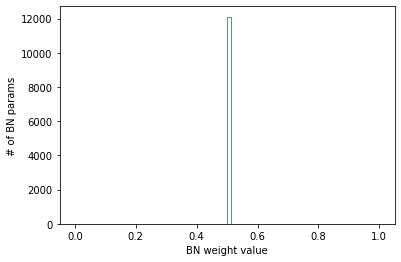

In [4]:
plot_init_bn_param()

In [88]:
orig_model = models.__dict__['resnet'](dataset='cifar10', depth=164)
# calculate size of all bn parameters 
total = 0
for m in orig_model.modules():
    if isinstance(m, nn.BatchNorm2d):
        total += m.weight.data.shape[0]
bn = torch.zeros(total)
print("number of bn parameters: ",total)

number of bn parameters:  12112


total # of bn params:  12112


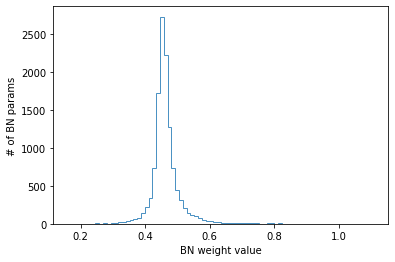

In [89]:
before_prune_1 = '/userhome/34/gyu/logs_sr/3wk_p1/train1/checkpoint.pth.tar'
load_ckpt_plot_bn_param(before_prune_1)

total # of bn params:  10900


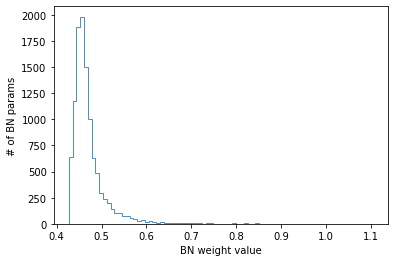

In [90]:
prune_1 = '/userhome/34/gyu/logs_sr/3wk_p1/prune1/pruned.pth.tar'
load_ckpt_plot_bn_param(prune_1)

total # of bn params:  10900


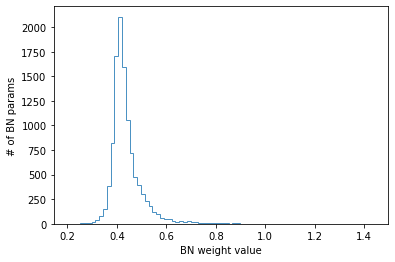

In [93]:
train2 = '/userhome/34/gyu/logs_sr/3wk_p1/train2/checkpoint.pth.tar'
load_ckpt_plot_bn_param(train2)

total # of bn params:  9809


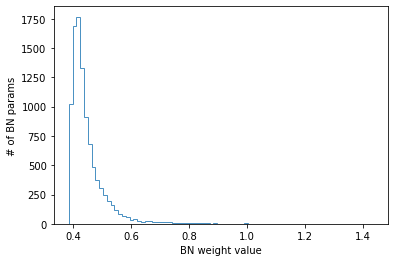

In [94]:
prune2 = '/userhome/34/gyu/logs_sr/3wk_p1/prune2/pruned.pth.tar'
load_ckpt_plot_bn_param(prune2)

total # of bn params:  9809


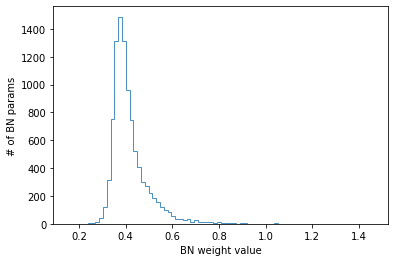

In [95]:
train3 = '/userhome/34/gyu/logs_sr/3wk_p1/train3/checkpoint.pth.tar'
load_ckpt_plot_bn_param(train3)

total # of bn params:  7945


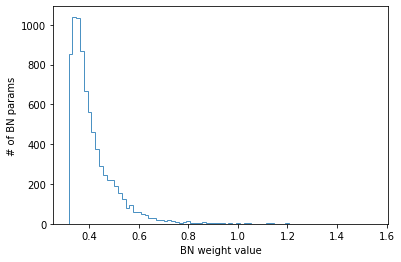

In [96]:
prune4 = '/userhome/34/gyu/logs_sr/3wk_p1/prune4/pruned.pth.tar'
load_ckpt_plot_bn_param(prune4)

total # of bn params:  7945


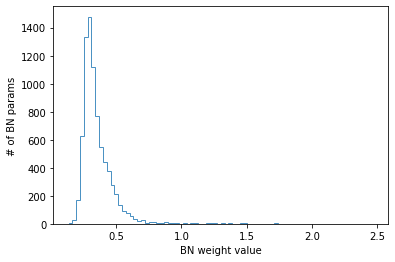

In [78]:
iterprune_124 = '/userhome/34/gyu/git-repo/rethinking-network-pruning/cifar/network-slimming/iterative_pruning/train124/checkpoint.pth.tar'
load_ckpt_plot_bn_param(iterprune_124)

total # of bn params:  12112


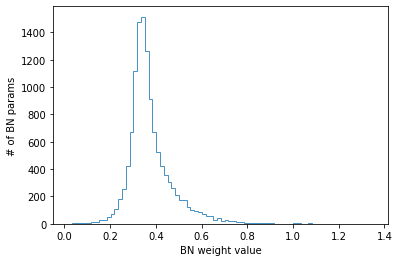

In [79]:
before_prune_once = '/userhome/34/gyu/git-repo/rethinking-network-pruning/cifar/network-slimming/logs/checkpoint.pth.tar'
load_ckpt_plot_bn_param(before_prune_once)


total # of bn params:  7946


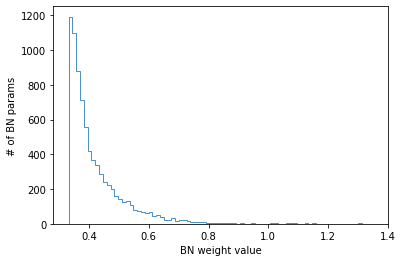

In [80]:
prune_once = '/userhome/34/gyu/git-repo/rethinking-network-pruning/cifar/network-slimming/logs/prune_3439/pruned.pth.tar'
load_ckpt_plot_bn_param(prune_once)


total # of bn params:  7946


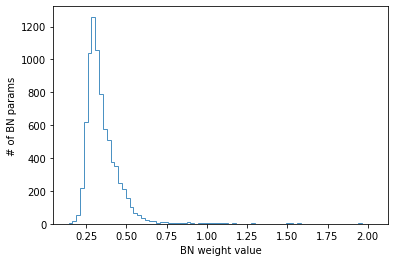

In [81]:
prune_once_after124 = '/userhome/34/gyu/git-repo/rethinking-network-pruning/cifar/network-slimming/logs/train_epoch_124/checkpoint.pth.tar'
load_ckpt_plot_bn_param(prune_once_after124)

In [34]:
prune_1 = '/userhome/34/gyu/git-repo/rethinking-network-pruning/cifar/network-slimming/iterative_pruning/prune1/pruned.pth.tar'
prune_2 = '/userhome/34/gyu/git-repo/rethinking-network-pruning/cifar/network-slimming/iterative_pruning/prune2/pruned.pth.tar'
prune_4 = '/userhome/34/gyu/git-repo/rethinking-network-pruning/cifar/network-slimming/iterative_pruning/prune4/pruned.pth.tar'
prune_once = '/userhome/34/gyu/git-repo/rethinking-network-pruning/cifar/network-slimming/logs/train_epoch_124/checkpoint.pth.tar'

model0 = models.__dict__['resnet'](dataset='cifar10', depth=164)

checkpoint1 = torch.load(prune_1)
model1 = models.__dict__['resnet'](dataset='cifar10', depth=164, cfg=checkpoint1['cfg'])
model1.load_state_dict(checkpoint1['state_dict'])                

checkpoint2 = torch.load(prune_2)
model2 = models.__dict__['resnet'](dataset='cifar10', depth=164, cfg=checkpoint2['cfg'])
model2.load_state_dict(checkpoint2['state_dict'])                

checkpoint4 = torch.load(prune_4)
model4 = models.__dict__['resnet'](dataset='cifar10', depth=164, cfg=checkpoint4['cfg'])
model4.load_state_dict(checkpoint4['state_dict'])                

checkpoint_prune_once = torch.load(prune_once)
model_prune_once = models.__dict__['resnet'](dataset='cifar10', depth=164, cfg=checkpoint_prune_once['cfg'])
model_prune_once.load_state_dict(checkpoint_prune_once['state_dict'])                


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [35]:
def count_conv_channels(model):
    sum_channel = 0.0
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            sum_channel += m.in_channels
#     print(sum_channel)
    return sum_channel

In [36]:
count_conv_channels(model0)

12067.0

In [37]:
count_conv_channels(model1)

10933.0

In [38]:
count_conv_channels(model2)

9842.0

In [39]:
count_conv_channels(model4) / count_conv_channels(model0)

0.6612248280434242

In [41]:
count_conv_channels(model_prune_once)

7928.0

In [42]:
7928 / 12067

0.6569984254578602

In [66]:
def check_bn_before_cs(model):
    zeros = 0
    module_list = list(model.modules())
    for i in range(len(module_list)):
        m = module_list[i]
        if (i + 1< len(module_list)) and isinstance(m, nn.BatchNorm2d) and isinstance(module_list[i+1],channel_selection):
            zeros += torch.sum(m.weight.data.eq(0))
    print(zeros)
            

In [67]:
check_bn_before_cs(model_prune_once)

tensor(3322)


In [85]:
model_prune_once.cuda()
summary(model_prune_once,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
 channel_selection-3           [-1, 12, 32, 32]               0
              ReLU-4           [-1, 12, 32, 32]               0
            Conv2d-5           [-1, 12, 32, 32]             144
       BatchNorm2d-6           [-1, 12, 32, 32]              24
              ReLU-7           [-1, 12, 32, 32]               0
            Conv2d-8           [-1, 15, 32, 32]           1,620
       BatchNorm2d-9           [-1, 15, 32, 32]              30
             ReLU-10           [-1, 15, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]             960
           Conv2d-12           [-1, 64, 32, 32]           1,024
       Bottleneck-13           [-1, 64, 32, 32]               0
      BatchNorm2d-14           [-1, 64,